In [1]:
import os 
import sys
import copy 
import time
import pickle
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

---

ref: https://github.com/huggingface/notebooks/blob/main/transformers_doc/en/multilingual.ipynb

Q1. mBERT or XLM-R ?    
Ans. XLM-R because it is more recent.

Q2. Fine-tuning or Use of Adapters? If fine-tuning then translate-train or translate-test?   
Ans. Let's start with fine-tuning as parameter efficiency is not essential for us.

Q3. Which languages (out of the total 14) to use? Can we remove langues which are totally unrelated to the test languages (Chinese, Hindi, Swahili and Spanish)?

Q4. Should we create 4 models (one for each of the 4 languages) or 1 model (for all 4 languages)?  

List of Experiments: 
1. - Start with a single **XLM-R** model and use all the **14** provided languages to **fine-tune** it.
   - Identify and **remove noisy languages** (from the 14 languages) then **fine-tune**. 
2. Create 4 separate language models for each of the 4 test languages. 
   - Each model uses all the training languages for fine-tuning. 
   - Each model uses only the languages which are closer to the corresponding model's test language. 
3. Use of Adapters ...

**Fine-tuning strategies:**
- Translate-train: 
    - translate all data to target language 'x' and fine-tune the model corresponding to 'x' on the translated data 
    - might lead to noisy data due to poor translations
- Translate-test: 
    - PROS:
        - train on original English data only
        - at inference, translate the target language sentence to English
        - maybe a better approach as the number of translation to be made is less and, generally, \
          translations into english are more accurate than translations from english to a different language. 
    - CONS:
        - Unutilized training data of other languages 

---

## Data Analysis

In [2]:
# data = pd.read_csv("/home/ddsb01/Desktop/NLP/Assign/A3/data/train/train.tsv", sep='\t')
data = pd.read_csv("data/train/train.tsv", sep='\t')
print(data.shape)
data.head()

(114993, 4)


,gold_label,premise,hypothesis,language
0,neutral,"At ground level, the asymmetrical cathedral is...",It's hard to find a dramatic view of the cathe...,en
1,contradiction,Hanuman is a beneficent deity predating classi...,Hanuman declared that all the lemurs here need...,en
2,contradiction,All other spending as well as federal revenue ...,None of the federal spending is assumed to grow,en
3,neutral,uh-huh that's interesting well it sounds as th...,That information about graduation rates is int...,en
4,neutral,Some kind of instant recognition on his father...,Did his father recognize him?,en


In [3]:
all_data = copy.deepcopy(data)

In [4]:
print(data.shape)
data.head()

(112993, 4)


,gold_label,premise,hypothesis,language
0,neutral,"At ground level, the asymmetrical cathedral is...",It's hard to find a dramatic view of the cathe...,en
1,contradiction,Hanuman is a beneficent deity predating classi...,Hanuman declared that all the lemurs here need...,en
2,contradiction,All other spending as well as federal revenue ...,None of the federal spending is assumed to grow,en
3,neutral,uh-huh that's interesting well it sounds as th...,That information about graduation rates is int...,en
4,neutral,Some kind of instant recognition on his father...,Did his father recognize him?,en


In [5]:
cols = data.columns
cols

Index(['gold_label', 'premise', 'hypothesis', 'language'], dtype='object')

In [6]:
eng_data = data[data['language']=='en']
print(eng_data.shape)
eng_data.head()

(100993, 4)


,gold_label,premise,hypothesis,language
0,neutral,"At ground level, the asymmetrical cathedral is...",It's hard to find a dramatic view of the cathe...,en
1,contradiction,Hanuman is a beneficent deity predating classi...,Hanuman declared that all the lemurs here need...,en
2,contradiction,All other spending as well as federal revenue ...,None of the federal spending is assumed to grow,en
3,neutral,uh-huh that's interesting well it sounds as th...,That information about graduation rates is int...,en
4,neutral,Some kind of instant recognition on his father...,Did his father recognize him?,en


In [7]:
eng_data = data[data['language']=='ur']
print(eng_data.shape)
eng_data.head()

(0, 4)


,gold_label,premise,hypothesis,language


In [8]:
target_langs = ['hi', 'sw', 'zh', 'es']
target_languages = ['Hindi', 'Swahili', 'Chinese', 'Spanish']

['bg' 'de' 'el' 'en' 'es' 'fr' 'hi' 'ru' 'sw' 'th' 'tr' 'vi' 'zh']
{'bg': 1000, 'de': 1000, 'el': 1000, 'en': 100993, 'es': 1000, 'fr': 1000, 'hi': 1000, 'ru': 1000, 'sw': 1000, 'th': 1000, 'tr': 1000, 'vi': 1000, 'zh': 1000}


<BarContainer object of 13 artists>

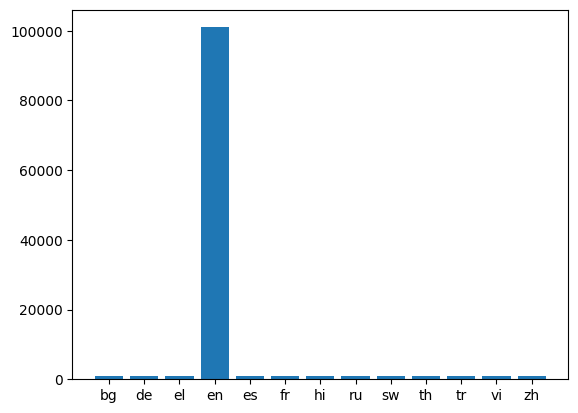

In [9]:
# different languages present in the data:
langs = np.unique(data['language'])
print(langs)

lang_dict = {} 
for lang in langs:
    lang_dict[lang] = data[data['language']==lang].shape[0]
print(lang_dict)
plt.bar(lang_dict.keys(), height=lang_dict.values())

['contradiction' 'entailment' 'neutral']
{'contradiction': 39465, 'entailment': 38113, 'neutral': 35415}


<BarContainer object of 3 artists>

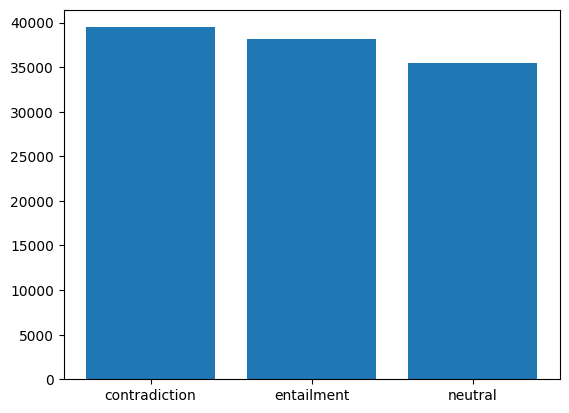

In [10]:
labels = np.unique(data['gold_label'])
print(labels)

label_dict = {}
for label in labels:
    label_dict[label] = data[data['gold_label']==label].shape[0]
print(label_dict)
plt.bar(label_dict.keys(), height=label_dict.values())

In [11]:
# Keeping a copy of the originial data:
orig_data = copy.deepcopy(data)
train_data = copy.deepcopy(data)

In [12]:
# xnli_dev = pd.read_csv("/home/ddsb01/Desktop/NLP/Assign/A3/data/xnli/xnli.dev.tsv", sep='\t') 
# xnli_test = pd.read_csv("/home/ddsb01/Desktop/NLP/Assign/A3/data/xnli/xnli.test.tsv", sep='\t')
xnli_dev = pd.read_csv("data/xnli/xnli.dev.tsv", sep='\t') 
xnli_test = pd.read_csv("data/xnli/xnli.test.tsv", sep='\t')
print(xnli_dev.shape, xnli_test.shape)

(37350, 19) (75150, 19)


In [13]:
xnli_test.columns

Index(['language', 'gold_label', 'sentence1_binary_parse',
       'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse',
       'sentence1', 'sentence2', 'promptID', 'pairID', 'genre', 'label1',
       'label2', 'label3', 'label4', 'label5', 'sentence1_tokenized',
       'sentence2_tokenized', 'match'],
      dtype='object')

In [14]:
genres = np.unique(xnli_test['genre']) 
print(genres) 
print(genres.shape)

['facetoface' 'fiction' 'government' 'letters' 'nineeleven' 'oup' 'slate'
 'telephone' 'travel' 'verbatim']
(10,)


In [15]:
req_cols = ['gold_label', 'sentence1', 'sentence2', 'language', 'genre'] 
# required: ['gold_label', 'premise', 'hypothesis', 'language']
# taking 'genre' as well for possible finer fine-tuning (since we know the test genres)

val_data_from_dev = xnli_dev[(xnli_dev['language']=='hi') | (xnli_dev['language']=='zh') | (xnli_dev['language']=='sw') | (xnli_dev['language']=='es')][req_cols] # 2.5k per language (the 1k given to us belong here i.e., it contains the target languages' training data itself!)
# val_data_from_test = xnli_test[(xnli_test['language']=='hi') | (xnli_test['language']=='zh') | (xnli_test['language']=='sw') | (xnli_test['language']=='es')][req_cols] # 5k per language
# dfs = [val_data_from_dev, val_data_from_test]
# val_data = pd.concat(dfs)
val_data=val_data_from_dev
print(val_data.shape)

# rename the columns to match 'data'
val_data.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis'}, inplace=True)
# val_data.to_csv('/home/ddsb01/Desktop/NLP/Assign/A3/data/train/val.tsv', sep='\t', index=False)
val_data = pd.read_csv("data/train/val.tsv", sep='\t')
# val_data.to_csv('train/val1.tsv', sep='\t', index=False)

(9960, 5)


In [16]:
# val_data = pd.read_csv("/home/ddsb01/Desktop/NLP/Assign/A3/data/train/val.tsv", sep='\t') 
val_data = pd.read_csv("data/train/val.tsv", sep='\t') 
# val_data = pd.read_csv("train/val1.tsv", sep='\t')
print(val_data.shape)
val_data.head()

(9960, 5)


,gold_label,premise,hypothesis,language,genre
0,neutral,"Y él dijo: Mamá, estoy en casa.",Llamó a su madre tan pronto como el autobús es...,es,facetoface
1,contradiction,"Y él dijo: Mamá, estoy en casa.",Él no dijo una palabra.,es,facetoface
2,entailment,"Y él dijo: Mamá, estoy en casa.",Le dijo a su madre que había llegado a casa.,es,facetoface
3,neutral,"No sabía para qué iba ni nada, así que iba a i...","Nunca he estado en Washington, así que cuando ...",es,facetoface
4,contradiction,"No sabía para qué iba ni nada, así que iba a i...",Sabía exactamente lo que tenía que hacer mient...,es,facetoface


In [17]:
# filter the val_data to include only the probable test genres (5 out of the total 10 genres)
genre_val_data = val_data[
                            (val_data['genre']=='facetoface') | 
                            (val_data['genre']=='fiction') |
                            (val_data['genre']=='oup') |
                            (val_data['genre']=='telephone') |
                            (val_data['genre']=='travel') 
                         ]
genre_val_data.shape

(4980, 5)

In [18]:
# taking all of xnli_test for validation
all_val_data = xnli_test[req_cols]
all_val_data.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis'}, inplace=True) 
print(all_val_data.shape)
all_val_data.head()

(75150, 5)


,gold_label,premise,hypothesis,language,genre
0,contradiction,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,لم أتحدث معه مرة أخرى.,ar,facetoface
1,entailment,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,كنت مستاء جدا لدرجة أنني بدأت بالحديث معه مرة ...,ar,facetoface
2,neutral,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,دار بيننا حديث رائع.,ar,facetoface
3,neutral,واعتقدت أن ذلك شرف لي ، ولا يزال ، ولايزال ، ك...,لم أكن على علم بأنني لم أكن الشخص الوحيد الذي ...,ar,facetoface
4,entailment,واعتقدت أن ذلك شرف لي ، ولا يزال ، ولايزال ، ك...,كان لدي إنطباع أنني كنت الشخص الوحيد الذي لديه...,ar,facetoface


Training/Fine-tuning on languages **unrelated** to the target languages might just be noise. Will removing unrelated languages help?           

What is an unrelated language? One way is to differentiate as left-to-right vs right-to-left. Another way is phylogenetic trees.        

We could also explore fine-tuning on some other task which might help in this NLI task? However, the restriction would be that we have to somehow use the given data only" 

We have been given data from xnli_dev corresponding to 5 genres: {'facetoface', 'fiction', 'telephone', 'oup', 'travel'}   
However, we will all the samples (i.e., samples corresponding to all the genres) of the target languages from xnli_test for validaition.

---

## Model

*Multi-lingual Language Models*

- XLMR
    - xlm-roberta-base (Masked language modeling, 100 languages) [Use this first]
    - xlm-roberta-large (Masked language modeling, 100 languages)

- BERT (or mBERT)  
    - bert-base-multilingual-uncased (Masked language modeling + Next sentence prediction, 102 languages)
    - bert-base-multilingual-cased (Masked language modeling + Next sentence prediction, 104 languages) [New and better] 


*Translation Models* 
- m2m100
    - facebook/m2m100_418M (Translation)
    - facebook/m2m100_1.2B (Translation)


https://towardsdatascience.com/how-to-apply-bert-to-arabic-and-other-languages-5c3410ddd787

Q. Why are we using XLM-R (which is multilingual) instead of single BERT (or other) models for each language? 
Ans. Because of lack of data or because of existence of many *low-resource* language. mBERT is another option but XLM-R has been found to perform better. 

Q. Do we need to translate-train when working with XLM-R?
Ans. NO! XLM-R has a shared vocabulary of 250K tokens corresponding to 100 languages which cover all the languages that we are using so there is no need to do any translations into english (or any other language) at test time. Also, no need to add any special markers to indicate the language at the time of fine-tuning.

In [19]:
#  !pip install transformers datasets

     |████████████████████████████████| 5.5 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 451 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 7.6 MB 36.1 MB/s eta 0:00:01     |██████████████████████████████▋ | 7.3 MB 36.1 MB/s eta 0:00:01
     |████████████████████████████████| 182 kB 50.5 MB/s eta 0:00:01
  Using cached multiprocess-0.70.14-py39-none-any.whl (132 kB)
     |████████████████████████████████| 35.9 MB 64.5 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 46.4 MB/s eta 0:00:01
  Using cached xxhash-3.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (212 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)


In [20]:
import torch
import transformers
from torch import nn

from transformers import logging
logging.set_verbosity_error()
logging.set_verbosity_warning()

from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split 
from transformers import AutoConfig, AutoTokenizer, AutoModel
from transformers import get_linear_schedule_with_warmup, AdamW
# from transformers import AutoModelForMaskedLM, XLMRobertaForSequenceClassification

from sklearn.metrics import f1_score

2022-11-26 14:21:30.153151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 14:21:30.299896: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-26 14:21:30.329864: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-26 14:21:30.821302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

References:    
- https://github.com/elsheikh21/cross-natural-language-inference/blob/master/XNLI_XLMR.ipynb 
- https://huggingface.co/salesken/xlm-roberta-base-finetuned-mnli-cross-lingual-transfer
- https://github.com/SumitM0432/XLM-RoBERTa-for-Textual-Entailment/tree/e551343fc7b2712744ad6b5ca51abbf824ef417c
- https://github.com/PrayushiFaldu/COL772/blob/master/Assignment_3/2021CSY7548_A3_B_train.ipynb   

In [21]:
# Hyperparameters ...

# global meta
MAX_LEN = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
VAL_SIZE = 0.3 # => 30% validation data
DROP_PROB = 0.1 # dropout probability; higher drop_prob => poor results
LR = 5e-6 # higher learning rate => poor results
EXT_VAL_DATA = True
REMOVE_UNREALTED_LANGS = False
ONLY_TRAIN_TARGETS_AND_ENG = False # Target langugages alongwith "English"
ONLY_TRAIN_TARGETS = False 

MODEL_NAME = 'xlm-roberta-large' # 'xlm-roberta-base' 'xlm-roberta-large'

TRANSLATE_INPUT_TRAIN = False 
TRANSLATE_INPUT_TEST = False

DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(torch.cuda.current_device())
RANDOM_SEED = 7

# Language strings will be used at inference: 
## might not be used at all since XLM-R identifies languages on it's own w/o need of any language indicators
LABEL2STR = {'ar': 'Arabic', 'bg': 'Bulgarian', 'de': 'German', 'el': 'Greek', 'en':'English', 'es': 'Spanish', 
             'fr': 'French', 'hi': 'Hindi', 'ru': 'Russian' ,'sw': 'Swahili', 'th': 'Thai', 'tr': 'Turkish', 
             'ur': 'Urdu', 'vi': 'Vietnamese', 'zh': 'Chinese'}
STR2LABEL = {v:k for k, v in LABEL2STR.items()}

label2idx = {'entailment':0, 'neutral':1, 'contradiction':2} 
idx2label = {v:k for k, v in label2idx.items()}
NUM_CLASSES = 3

xlmr_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) 
# xlmr_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)
xlmr_tokenizer.do_lower_case = False # setting explicitly because sometimes the above line doesn't work  

**Data Preprocessing**

In [ ]:
if REMOVE_UNREALTED_LANGS:
    # Not taking two languages: "Arabic" and "Urdu" while training. 
    # The four target languages are written left-to-right while these two are written right-to-left
    # Removing these languages helps in improving the accuracy over the target languages, 
    # probably bcz these languages are unrelated to the target languages to a large extent and therefore add noise while training 
    data = data[
            (data['language']=='hi') | 
            (data['language']=='zh') | 
            (data['language']=='sw') | 
            (data['language']=='es') | 
            (data['language']=='bg') | 
            (data['language']=='de') | 
            (data['language']=='el') | 
            (data['language']=='en') | 
            (data['language']=='fr') | 
            (data['language']=='ru') | 
            (data['language']=='th') | 
            (data['language']=='tr') | 
            (data['language']=='vi') 
            ]

if ONLY_TRAIN_TARGETS_AND_ENG:
    data = data[
            (data['language']=='en') | 
            (data['language']=='hi') | 
            (data['language']=='zh') | 
            (data['language']=='sw') | 
            (data['language']=='es') 
            ]

if ONLY_TRAIN_TARGETS:
    data = data[
            (data['language']=='hi') | 
            (data['language']=='zh') | 
            (data['language']=='sw') | 
            (data['language']=='es') 
            ]

In [22]:
# Utilities
def translate_data(all_data):
    pass

def preprocess_data(all_data):
    '''
    # We don't need to translate any sample in all_data bcz all of the samples are from languages on which XLM-R is trained.
    # Not required bcz languages can be fed into XLMR w/o translation
    if TRANSLATE_INPUT_TRAIN:
        # make use of all the input data by converting all the other languages to english
        all_data = translate_data(all_data)
    else:
        # only train on 'English' data samples only
        all_data = all_data[all_data['language']=='en']
    '''
    proposition = all_data[['premise', 'hypothesis']].values.tolist()
    all_data['proposition'] = proposition
    # print(all_data.shape)
    all_data = all_data.dropna() # https://stackoverflow.com/questions/63517293/valueerror-textencodeinput-must-be-uniontextinputsequence-tupleinputsequence
    # print(all_data.shape)
    return all_data


def split_data(all_data):
    # for validation take only 30% of the target languages' {Hindi, Chinese, Swahili, Spanish} data
    target_langs_data = all_data[(all_data['language']=='hi') | (all_data['language']=='zh') | (all_data['language']=='sw') | (all_data['language']=='es')]
    target_train, X_test, y_target_train, y_test = train_test_split(
                                                                    target_langs_data, 
                                                                    target_langs_data.gold_label,
                                                                    test_size=VAL_SIZE,
                                                                    random_state=RANDOM_SEED,
                                                                    stratify=target_langs_data.gold_label.map(label2idx).values
                                                                    )
    other_langs_data = all_data[~((all_data['language']=='hi') | (all_data['language']=='zh') | (all_data['language']=='sw') | (all_data['language']=='es'))]

    dfs = [other_langs_data, target_train]
    X_train = pd.concat(dfs)
    y_train = X_train['gold_label']
    return X_train, X_test, y_train, y_test
    

def _split_data(all_data):
    # for validation take only 30% of the target languages' {Hindi, Chinese, Swahili, Spanish} data
    X_train, X_test, y_train, y_test = train_test_split(
                                                        # all_data['proposition'],
                                                        all_data,
                                                        all_data.gold_label, 
                                                        # all_data.gold_label.map(label2idx).values,
                                                        test_size=VAL_SIZE, 
                                                        random_state=RANDOM_SEED, 
                                                        stratify=all_data.gold_label.map(label2idx).values
                                                        )
    return X_train, X_test, y_train, y_test



def encode_data(X, y, tokenizer):
    '''
    X : Propositions
    y : labels <=> X_['gold_label'] if all_data instead of all_data['proposition'] in split_data
    
    text=premise, text_pair=hypothesis, ... makes more sense than text=proposition
    bcz in the former case, the segment tokens for text and text_pair are different
    '''
    encoded_data = []
    for _premise, _hypothesis, _label in tqdm(zip(X['premise'], X['hypothesis'], X['gold_label']), total=X.shape[0]):
        encoded_dict = tokenizer(
                                 text=_premise,
                                 text_pair=_hypothesis, 
                                 # target=?, # what is its use?
                                 add_special_tokens=True,
                                 return_token_type_ids=True, # token_type_ids like [CLS],[SEP],etc.
                                 return_attention_mask=True,
                                 max_length=MAX_LEN,
                                 padding='max_length',
                                 truncation=True,
                                 return_tensors='pt' #'pt'=>torch.Tensor object
                                )
        encoded_data.append({
                             # 'premise': _premise, '_hypothesis': _hypothesis,
                             'tokenized_text': torch.squeeze(encoded_dict["input_ids"]), # <=> # 'tokenized_text': encoded_dict["input_ids"].flatten(),
                             'attention_mask': torch.squeeze(encoded_dict["attention_mask"]), 
                             'token_types': torch.squeeze(encoded_dict["token_type_ids"]),
                             'outputs': torch.LongTensor([label2idx.get(_label)]) # casting to LongTensor is important (for the loss_fn later on; either cast here itself or in the training loop) 
                            })
    '''
    for _proposition, _label in tqdm(zip(X, y), total=X.shape[0]):
        encoded_dict = tokenizer(
                                    text=proposition,
                                    add_special_tokens=True,
                                    return_token_type_ids=True, # token_type_ids like [CLS],[SEP],etc.
                                    padding = 'max_length',
                                    truncation=True,
                                    max_length=MAX_LEN,
                                    return_tensors='pt' #'pt'=>torch.Tensor object
                                )
        encoded_data.append({
                             'propositions': prop, 
                             'tokenized_text': torch.squeeze(encoded_dict["input_ids"]), # <=> # 'tokenized_text': encoded_dict["input_ids"].flatten(),
                             'attention_mask': torch.squeeze(encoded_dict["attention_mask"]), 
                             'token_types': torch.squeeze(encoded_dict["token_type_ids"]),
                             'outputs': torch.LongTensor([label2idx.get(_label)])
                            })
    '''
    return encoded_data


def create_dataloader(encoded_data):
    return DataLoader(encoded_data, batch_size=BATCH_SIZE)


Attention masks are boolean arrays which tell which token should be attended to, and which should not.
The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.

**Training**
---

This is a Translate-train-all setting where the data of all the languages (which have been achieved via translation) is also used on top of the source language (usually English) for training.  

In [23]:
# PREPROCESS the original data, SPLIT into train and val data, ENCODE train data, get the DATALOADER 
processed_data = preprocess_data(data)
# if not taking external data for validation 
if not EXT_VAL_DATA:
    X_train, X_val, y_train, y_val = split_data(processed_data) 

# if using external data for validation:
if EXT_VAL_DATA:
    X_train, y_train = train_data.applymap(str), train_data['gold_label']
    X_val, y_val = val_data.applymap(str), val_data['gold_label']

# X_train, X_val, y_train, y_val = X_train[:BATCH_SIZE], X_val[:BATCH_SIZE], y_train[:BATCH_SIZE], y_val[:BATCH_SIZE] 
# X_train, X_val, y_train, y_val = X_train[:100*BATCH_SIZE], X_val[:100*BATCH_SIZE], y_train[:100*BATCH_SIZE], y_val[:100*BATCH_SIZE] 

train_input = encode_data(X_train, y_train, xlmr_tokenizer)
val_input = encode_data(X_val, y_val, xlmr_tokenizer)
NUM_TRAIN_SAMPLES = len(train_input)
NUM_VAL_SAMPLES = len(val_input)

train_dataloader = create_dataloader(train_input)
val_dataloader = create_dataloader(val_input)
NUM_TRAIN_BATCHES = len(train_dataloader)
NUM_VAL_BATCHES = len(val_dataloader)

100%|█████████████████████████████████████| 9960/9960 [00:03<00:00, 2789.45it/s]


In [25]:
# Ignore
'''
# How to choose the MAX_LEN hyperparameter:
# choose a multiple of 2 close to the max length of the input:
def get_max_len(dataset):
    max_len = 0
    for sample in dataset:
        curr_len = sample['tokenized_text'].shape[1]
        if curr_len > max_len:
            max_len = curr_len 
    return max_len 

max_len_train = get_max_len(train_input) 
max_len_val = get_max_len(val_input)

print(max_len_train, max_len_val)
'''

"\n# How to choose the MAX_LEN hyperparameter:\n# choose a multiple of 2 close to the max length of the input:\ndef get_max_len(dataset):\n    max_len = 0\n    for sample in dataset:\n        curr_len = sample['tokenized_text'].shape[1]\n        if curr_len > max_len:\n            max_len = curr_len \n    return max_len \n\nmax_len_train = get_max_len(train_input) \nmax_len_val = get_max_len(val_input)\n\nprint(max_len_train, max_len_val)\n"

In [26]:
# Model class:
class xlmr_model(nn.Module):
    def __init__(self, n_classes):
        super(xlmr_model, self).__init__() 
        self.config = AutoConfig.from_pretrained(MODEL_NAME)
        self.model = AutoModel.from_pretrained(MODEL_NAME, num_labels=n_classes).to(DEVICE)
        self.drop = nn.Dropout(p=DROP_PROB) 
        classifier_input_dim = self.model.config.hidden_size
        self.classifier = nn.Linear(classifier_input_dim, n_classes) 
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(
                             input_ids = input_ids, 
                             attention_mask = attention_mask,
                             token_type_ids = token_type_ids
                             # labels = labels # deprecated
                             )
        last_hidden_state = outputs[0]  # outputs.last_hidden_state
        sentence_embeddings = torch.mean(last_hidden_state, dim=1) 
        
        pooler_output = outputs[1] # outputs.pooler_output
        
        # output = self.drop(pooler_output) 
        # pooler output gives processed cls tokens, it might not be the suitable option for nli; will see later
        output = self.drop(sentence_embeddings)
        # output = sentence_embeddings # when removing dropout, uncomment this line
        logits = self.classifier(output)
        return logits

In [27]:
model = xlmr_model(NUM_CLASSES).to(DEVICE) # the.to(DEVICE) used here might be redundant

optimizer = AdamW(model.parameters(), lr=LR, correct_bias=False)

total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
                                            optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps
                                            )

loss_fn = nn.CrossEntropyLoss().to(DEVICE) 
torch.cuda.empty_cache()

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TensorBoard (with PyTorch) tutorials:
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html   
- https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

In [28]:
# import tensorflow as tf
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(
#                        "runs/XLM-R for multilingual NLI", 
#                        comment=f"Learning Rate: {LR} with linear scheduler, Dropout Probability: {DROP_PROB}"
#                        ) 

In [29]:
# # Tensorboard stuff:
# %load_ext tensorboard # Load the TensorBoard notebook extension 
# !rm -rf ./logs/  # Clear any logs from previous runs

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
# tensorboard_callack = tf.keras.callbacks.TesnorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
# for a single epoch:
def train_epoch(model, dataloader):
    model.train()
    
    train_loss = 0.0 
    correct_preds = 0 
    num_samples = 0 
    num_batches = len(dataloader)
    
    all_targets = []
    all_preds = []
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    # for batch_idx, batch in enumerate(dataloader):
        ip_ids = batch['tokenized_text'].to(DEVICE)
        attn_mask = batch['attention_mask'].to(DEVICE)
        token_types = batch['token_types'].to(DEVICE)
        targets = batch['outputs'].to(DEVICE).view(-1)
        
        optimizer.zero_grad()
        
        preds = model(input_ids=ip_ids, attention_mask=attn_mask, token_type_ids=token_types)
        _, pred_labels = torch.max(preds, dim=1)
        correct_preds += torch.sum(pred_labels==targets)
        
        # The RHS gives #correct predictions for the 'b-th' batch after training on the previous (b-1) batches 
        # this value should improve as the model sees more batches
        # this 'correct' can differ from the 'correct' in case of 'accuracy(model, dataloader)' 
        # print(preds)
        # print()
        # print(targets)
        loss = loss_fn(preds, targets)
        train_loss += loss.item() 
        # first we evaluate then backpropagate
        loss.backward() 
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() 
        scheduler.step() 
        
        # num_samples += len(batch) # WRONG! # len(batch) will give the length of the batch dictionary which is 4
        num_samples += len(batch['outputs'])

        pred_batch, gold_batch = list(pred_labels.cpu().numpy()), list(targets.cpu().numpy()) 
        all_preds += pred_batch
        all_targets += gold_batch
    
    acc_this_epoch = correct_preds/num_samples
    # acc_this_epoch_ = eval_model(model, dataloader) # this can be different from acc_this_epoch
    loss_this_epoch = train_loss/num_batches
    
    micro_f1 = f1_score(all_targets, all_preds, average='micro')
    macro_f1 = f1_score(all_targets, all_preds, average='macro')

    return acc_this_epoch, train_loss, micro_f1, macro_f1


def eval_epoch(model, dataloader):
    model.eval() 
    
    val_loss = 0.0 
    correct_preds = 0 
    num_samples = 0 
    num_batches = len(dataloader)
    
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        # for batch_idx, batch in enumerate(dataloader):
            ip_ids = batch['tokenized_text'].to(DEVICE)
            attn_mask = batch['attention_mask'].to(DEVICE)
            token_types = batch['token_types'].to(DEVICE)
            targets = batch['outputs'].to(DEVICE).view(-1)
            
            preds = model(input_ids=ip_ids, attention_mask=attn_mask, token_type_ids=token_types) 
            _, pred_labels = torch.max(preds, dim=1)
            correct_preds += torch.sum(pred_labels==targets)

            loss = loss_fn(preds, targets) 
            val_loss += loss.item()
            
            num_samples += len(batch['outputs'])

            pred_batch, gold_batch = list(pred_labels.cpu().numpy()), list(targets.cpu().numpy()) 
            all_preds += pred_batch
            all_targets += gold_batch
                
    acc_this_epoch = correct_preds/num_samples 
    loss_this_epoch = val_loss/num_batches 
    
    micro_f1 = f1_score(all_targets, all_preds, average='micro')
    macro_f1 = f1_score(all_targets, all_preds, average='macro')

    return acc_this_epoch, loss_this_epoch, micro_f1, macro_f1


def save_model(model, idx):
    torch.save(model.state_dict(), f'model_{idx}.pth')
    return

def load_model(model_path):
    state_dict = torch.load(model_path)
    model = xlmr_model(NUM_CLASSES)
    model.load_state_dict(state_dict)
    return model

def save_history(history_dict):
    pickle_on = open('history_dict.pkl', 'wb')
    pickle.dump(history_dict, pickle_on)
    pickle_on.close()
    return

def load_history(history_dict_path):
    pickle_off = open(history_dict_path, 'rb')
    history = pickle.load(pickle_off)
    return history


def train(model, train_loader, val_loader, num_epochs):
    history = defaultdict(list)
    best_acc = 0

    start_time = time.time()
    print(f"Program execution start : {datetime.datetime.now()}")
    for epoch_idx in range(num_epochs):
        print("-"*100)
        print(f"Epoch {int(epoch_idx)}")
        
        train_acc, train_loss, train_micro_f1, train_macro_f1 = train_epoch(model, train_loader)
        # writer.add_scalar("Loss/train", train_loss, epoch_idx+1)
        # writer.add_scalar("Accuracy/train", train_acc, epoch_idx+1)
        print("Train Acc: {:6.3f} | Micro-F1: {:6.3f} | Macro-F1: {:6.3f} | Train Loss: {:6.3f}".format(train_acc, train_micro_f1, train_macro_f1, train_loss))
        
        val_acc, val_loss, val_micro_f1, val_macro_f1 = eval_epoch(model, val_loader)
        # writer.add_scalar("Loss/test", val_loss, epoch_idx+1)
        # writer.add_scalar("Accuracy/test", val_acc, epoch_idx+1)
        print("Val Acc: {:6.3f} | Micro-F1: {:6.3f} | Macro-F1: {:6.3f} | Val Loss: {:6.3f}".format(val_acc, val_micro_f1, val_macro_f1, val_loss))
        
        print("-"*100)

        history['train_accs'].append(train_acc.cpu().item()) # micro-F1
        history['train_losses'].append(train_loss)
        history['val_accs'].append(val_acc.cpu().item())
        history['val_losses'].append(val_loss)
        
        history['train_micro-f1'].append(train_micro_f1)
        history['train_macro-f1'].append(train_macro_f1)
        history['val_macro-f1'].append(val_micro_f1)
        history['val_macro-f1'].append(val_macro_f1)
        # saving the model at every checkpoint might take too much space but we don't care xD
        # we save the model at every epoch (each checkpoint's size is around 1.1 GB)
        # we also save the entire 'history' 
        # we'll select the one of the model checkpoints later based on the history 
        save_model(model, epoch_idx)
    
    save_history(history) 
    print(f"Program execution end : {datetime.datetime.now()}")
    print()
    end_time = time.time() 
    print(f"Total execution time: {(end_time-start_time)/3600} hrs")
    return

Q. What should be the MAX_LEN?    
Q. Give the concatenated {premise, hypothesis} as single input or consider separate inputs premise and hypothesis (in the latter case there will be separate segment embeddings for the two inputs which will necessiate the use of token_type_ids input for the model) i.e., 
- use Tokenizer(text=proposition, ...)
- use Tokenizer(text=premise, text_pair=hypothesis, ...)

In [31]:
train(model, train_dataloader, val_dataloader, NUM_EPOCHS)

Program execution start : 2022-11-26 14:22:26.224259
----------------------------------------------------------------------------------------------------
Epoch 0


100%|███████████████████████████████████████| 3532/3532 [43:11<00:00,  1.36it/s]


Train Acc:  0.815 | Train Loss: 1658.942


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.58it/s]


Val Acc:  0.849 | Val Loss:  0.464
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 1


100%|███████████████████████████████████████| 3532/3532 [43:08<00:00,  1.36it/s]


Train Acc:  0.886 | Train Loss: 1107.209


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.57it/s]


Val Acc:  0.865 | Val Loss:  0.562
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 2


100%|███████████████████████████████████████| 3532/3532 [43:07<00:00,  1.37it/s]


Train Acc:  0.914 | Train Loss: 870.121


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.56it/s]


Val Acc:  0.876 | Val Loss:  0.655
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 3


100%|███████████████████████████████████████| 3532/3532 [43:08<00:00,  1.36it/s]


Train Acc:  0.934 | Train Loss: 702.754


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.57it/s]


Val Acc:  0.873 | Val Loss:  0.721
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 4


100%|███████████████████████████████████████| 3532/3532 [43:08<00:00,  1.36it/s]


Train Acc:  0.949 | Train Loss: 568.411


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.56it/s]


Val Acc:  0.876 | Val Loss:  0.797
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 5


100%|███████████████████████████████████████| 3532/3532 [43:08<00:00,  1.36it/s]


Train Acc:  0.960 | Train Loss: 491.969


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.57it/s]


Val Acc:  0.878 | Val Loss:  0.835
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 6


100%|███████████████████████████████████████| 3532/3532 [43:09<00:00,  1.36it/s]


Train Acc:  0.967 | Train Loss: 427.765


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.57it/s]


Val Acc:  0.880 | Val Loss:  0.820
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 7


100%|███████████████████████████████████████| 3532/3532 [43:09<00:00,  1.36it/s]


Train Acc:  0.973 | Train Loss: 366.942


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.56it/s]


Val Acc:  0.878 | Val Loss:  0.888
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 8


100%|███████████████████████████████████████| 3532/3532 [43:08<00:00,  1.36it/s]


Train Acc:  0.977 | Train Loss: 331.473


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.56it/s]


Val Acc:  0.876 | Val Loss:  0.891
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 9


100%|███████████████████████████████████████| 3532/3532 [43:11<00:00,  1.36it/s]


Train Acc:  0.979 | Train Loss: 310.466


100%|█████████████████████████████████████████| 312/312 [01:08<00:00,  4.56it/s]


Val Acc:  0.874 | Val Loss:  0.855
----------------------------------------------------------------------------------------------------
Program execution end : 2022-11-26 21:45:56.576751

Total execution time: 7.391764610542191 hrs


In [32]:
# !tensorboard --logdir=runs

# writer.flush() 
# writer.close()

In [33]:
hist = load_history('history_dict.pkl')
print(hist)

defaultdict(<class 'list'>, {'train_accs': [0.8148115277290344, 0.8857274055480957, 0.9137203097343445, 0.9335445165634155, 0.9488729238510132, 0.9597674012184143, 0.9667412638664246, 0.973024845123291, 0.976892352104187, 0.9790252447128296], 'train_losses': [1658.941638402408, 1107.2093811953964, 870.1207627179974, 702.7540937981685, 568.4107035556808, 491.96895518913334, 427.7654407773771, 366.94175416487815, 331.4733188902792, 310.466303849229], 'val_accs': [0.8485943675041199, 0.8653614521026611, 0.8758032321929932, 0.8734939694404602, 0.8761044144630432, 0.8779116868972778, 0.8803213238716125, 0.8784136772155762, 0.8756024241447449, 0.873795211315155], 'val_losses': [0.4644244694455455, 0.5619034880353586, 0.6551157749402662, 0.7212011052497473, 0.7967371219077648, 0.8349079333425391, 0.8204258104133376, 0.8876115394754939, 0.890777366499081, 0.8545642026486185]})
